# Tarefa: Geração de imagens de roupas - base Fashion MNIST

Nesta tarefa você vai usar a base de dados Fashion MNIST, que possui 10 classes com tipos de roupas. O PyTorch já disponibiliza essa base de dados, bastando que você faça o carregamento igual já fizemos para a base de dados MNIST. Como as imagens também estão em escala de cinza e possuem as mesmas dimensões, não são necessárias alterações no código para fazer esse teste.

Abaixo você pode visualizar algumas das imagens que foram criadas. Como essa base de dados é um pouco mais complexa, sugerimos que você faça o treinamento por mais épocas, adicione mais camadas nas redes neurais e implemente uma rede neural convolucional para o discriminador

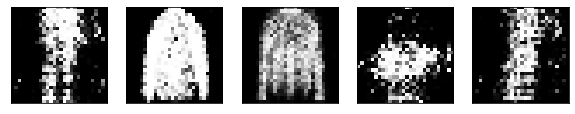

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 49.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


## Etapa 1: Importação das bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import optim
from torchvision import datasets

In [3]:
torch.manual_seed(123)

## Etapa 2: Base de dados

In [4]:
transform = transforms.ToTensor()
train = datasets.FashionMNIST(root='.', train = True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=256)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


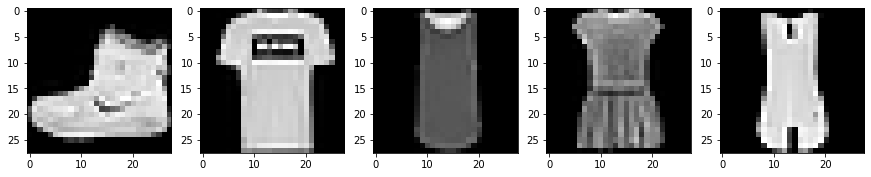

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(15,5))
for i in range(5):
  ax[i].imshow(train.data[i], cmap='gray')
plt.show()

In [6]:
train.data.shape

torch.Size([60000, 28, 28])

## Etapa 3: Construção do gerador

In [51]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.main = nn.Sequential(
        # nz will be the input to the first convolution
        nn.Conv2d(1, 256, kernel_size=28, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(256), nn.ReLU(True),

        nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128), nn.ReLU(True),
        
        nn.Flatten(),
        nn.Linear(128,256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(256,512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(512,784),
        nn.LeakyReLU(0.2, inplace=True),

        # nn.ConvTranspose2d(128, 784, kernel_size=3, stride=2, padding=1, bias=False),
        #nn.BatchNorm2d(32), nn.ReLU(True),

        #nn.Conv2d(512, 784, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
  def forward(self, input):
      return self.main(input).view(input.shape[0], 28,28)

## Etapa 4: Construção do discriminador

In [52]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.main = nn.Sequential(
        nn.Conv2d(784, 512, kernel_size=1, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(512, 256, kernel_size=1, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 128, kernel_size=1, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(128, 64, kernel_size=1, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),
        
        nn.Flatten(),
        nn.Linear(576,128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(128,64),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(64,32),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.2),

        nn.Linear(32,1),
        nn.LeakyReLU(0.2, inplace=True),
        #nn.Conv2d(32, 1, kernel_size=1, stride=4, padding=0, bias=False),
        #nn.BatchNorm2d(784), nn.LeakyReLU(0.2, inplace=True),

        #nn.Conv2d(784, 1, kernel_size=3, stride=1, padding=0, bias=False),
        nn.Tanh()
    )
  def forward(self, input):
      input = input.view(input.shape[0], 28*28,1,1)
      return self.main(input)

## Etapa 5: Criação dos objetos

In [121]:
G = Generator()
G_optim = optim.Adam(G.parameters(), lr=0.0002, betas=(0.3,0.999), weight_decay=.001)

In [122]:
D = Discriminator()
D_optim = optim.Adam(D.parameters(), lr = 0.0002, betas=(0.3,0.999), weight_decay=.001)

In [123]:
criterion = nn.BCEWithLogitsLoss()

In [124]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [125]:
G.to(device)

Generator(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(28, 28), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Flatten()
    (7): Linear(in_features=128, out_features=256, bias=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=256, out_features=512, bias=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=512, out_features=784, bias=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Tanh()
  )
)

In [126]:
D.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(784, 512, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(512, 256, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten()
    (13): Linea

In [127]:
ruido = np.random.uniform(low=-1., high=1., size=(256, 1, 28, 28))
ruido = torch.from_numpy(ruido).float().to(device)
img_gen = G.forward(ruido)

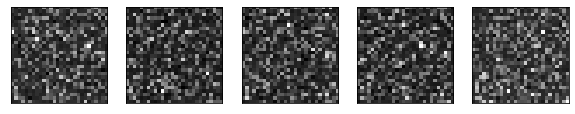

In [128]:
fig, ax = plt.subplots(1, 5, figsize=(10,5))
for i in range(5):
  ax[i].imshow(img_gen.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
  ax[i].xaxis.set_visible(False)
  ax[i].yaxis.set_visible(False)
plt.show()

In [129]:
img_gen.shape

torch.Size([256, 28, 28])

## Etapa 6: Treinamento do modelo

ÉPOCA 001 finalizada: custo discriminador 0.861834 - custo gerador 1.165506      


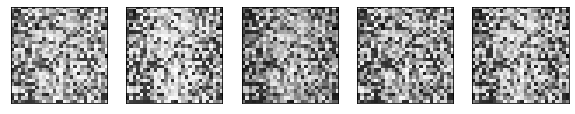

ÉPOCA 002 finalizada: custo discriminador 1.095374 - custo gerador 1.007885      


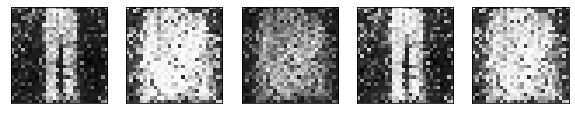

ÉPOCA 003 finalizada: custo discriminador 1.125736 - custo gerador 1.057631      


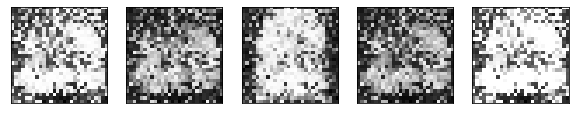

ÉPOCA 004 finalizada: custo discriminador 1.314489 - custo gerador 1.223673      


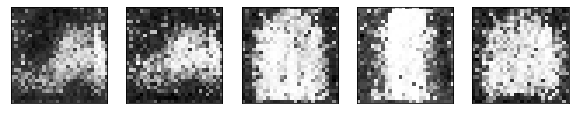

ÉPOCA 005 finalizada: custo discriminador 1.304711 - custo gerador 1.243777      


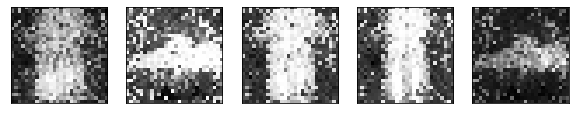

ÉPOCA 006 finalizada: custo discriminador 0.946612 - custo gerador 1.163442      


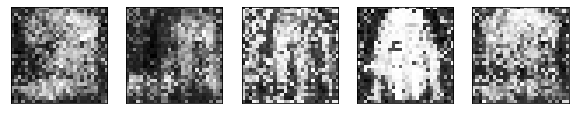

ÉPOCA 007 finalizada: custo discriminador 1.281955 - custo gerador 0.892804      


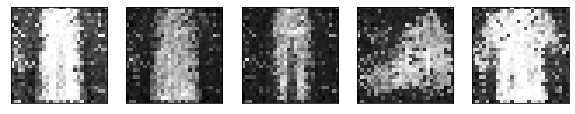

ÉPOCA 008 finalizada: custo discriminador 1.315056 - custo gerador 1.000392      


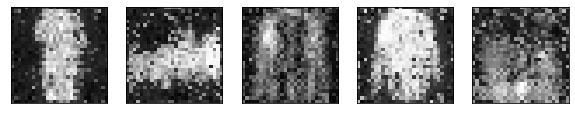

ÉPOCA 009 finalizada: custo discriminador 1.475965 - custo gerador 1.289593      


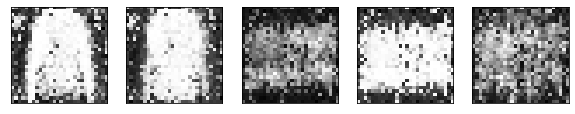

ÉPOCA 010 finalizada: custo discriminador 1.513208 - custo gerador 1.298496      


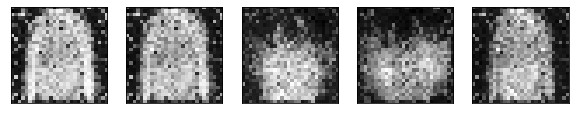

ÉPOCA 011 finalizada: custo discriminador 1.138219 - custo gerador 1.149222      


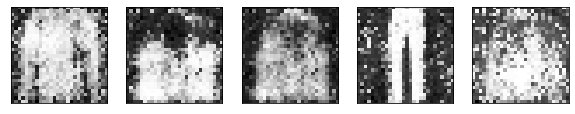

ÉPOCA 012 finalizada: custo discriminador 1.476141 - custo gerador 1.299090      


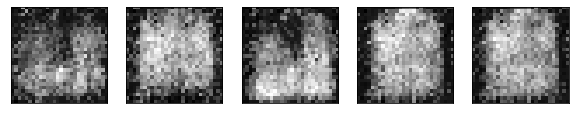

ÉPOCA 013 finalizada: custo discriminador 1.286655 - custo gerador 1.125327      


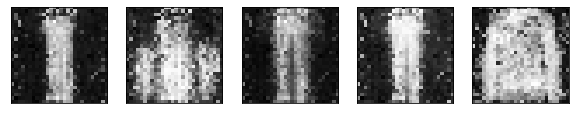

ÉPOCA 014 finalizada: custo discriminador 1.222454 - custo gerador 1.071178      


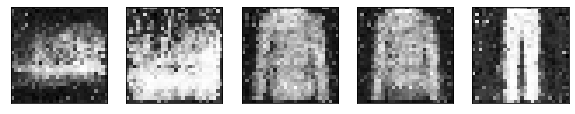

ÉPOCA 015 finalizada: custo discriminador 1.139967 - custo gerador 1.168443      


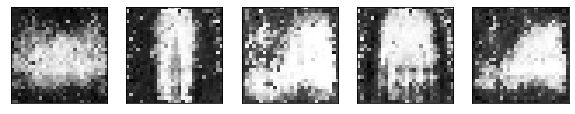

ÉPOCA 016 finalizada: custo discriminador 1.526327 - custo gerador 1.313207      


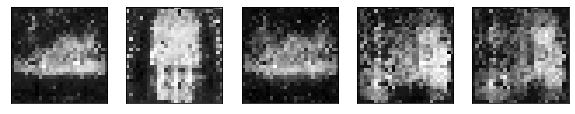

ÉPOCA 017 finalizada: custo discriminador 1.367458 - custo gerador 1.120837      


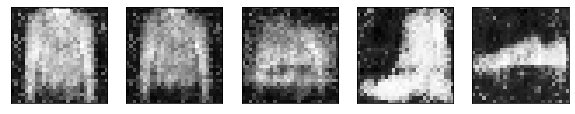

ÉPOCA 018 finalizada: custo discriminador 1.239518 - custo gerador 1.077703      


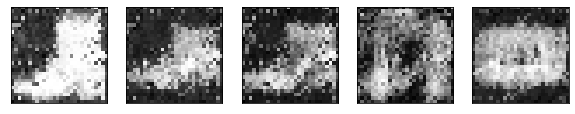

ÉPOCA 019 finalizada: custo discriminador 1.271757 - custo gerador 1.124592      


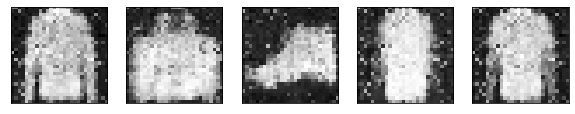

ÉPOCA 020 finalizada: custo discriminador 1.245313 - custo gerador 1.175911      


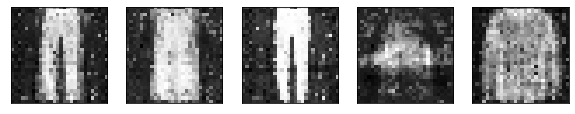

ÉPOCA 021 finalizada: custo discriminador 1.248472 - custo gerador 1.178486      


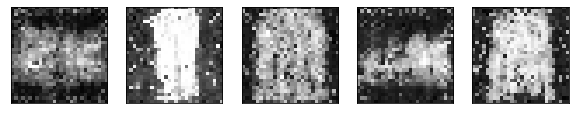

ÉPOCA 022 finalizada: custo discriminador 1.256598 - custo gerador 1.190407      


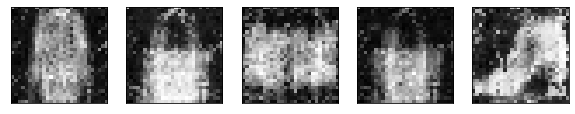

ÉPOCA 023 finalizada: custo discriminador 1.407509 - custo gerador 1.150031      


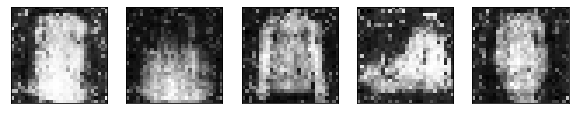

ÉPOCA 024 finalizada: custo discriminador 1.139650 - custo gerador 1.126246      


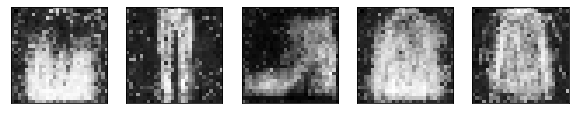

ÉPOCA 025 finalizada: custo discriminador 1.279769 - custo gerador 1.102920      


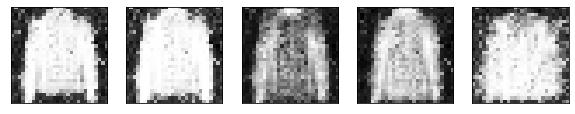

ÉPOCA 026 finalizada: custo discriminador 1.184033 - custo gerador 1.157965      


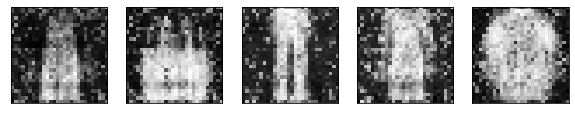

ÉPOCA 027 finalizada: custo discriminador 1.304558 - custo gerador 1.209288      


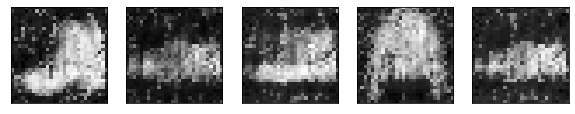

ÉPOCA 028 finalizada: custo discriminador 1.117866 - custo gerador 1.159037      


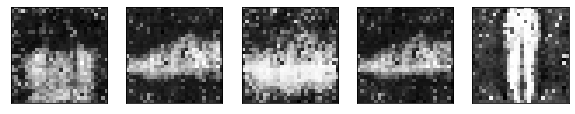

ÉPOCA 029 finalizada: custo discriminador 1.254639 - custo gerador 1.165335      


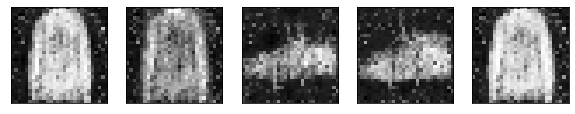

ÉPOCA 030 finalizada: custo discriminador 1.264670 - custo gerador 1.181153      


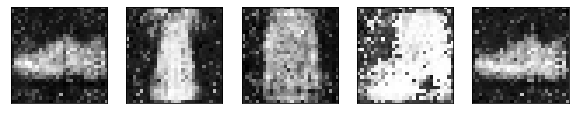

ÉPOCA 031 finalizada: custo discriminador 1.244083 - custo gerador 1.196889      


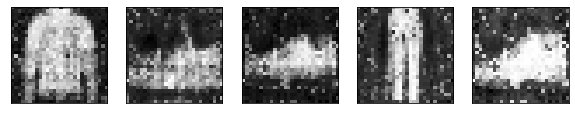

ÉPOCA 032 finalizada: custo discriminador 1.257901 - custo gerador 1.166674      


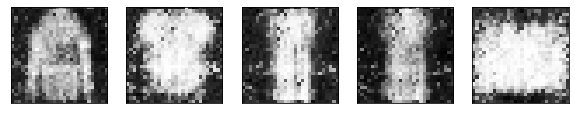

ÉPOCA 033 finalizada: custo discriminador 1.230149 - custo gerador 1.037233      


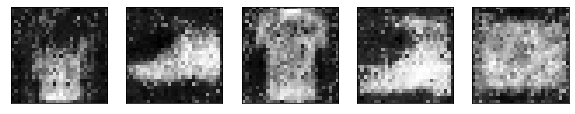

ÉPOCA 034 finalizada: custo discriminador 1.155775 - custo gerador 1.127706      


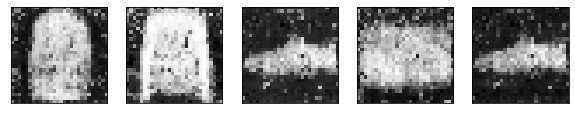

ÉPOCA 035 finalizada: custo discriminador 1.264519 - custo gerador 1.201993      


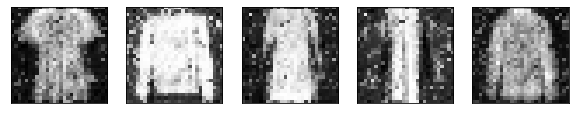

ÉPOCA 036 finalizada: custo discriminador 1.209642 - custo gerador 1.209253      


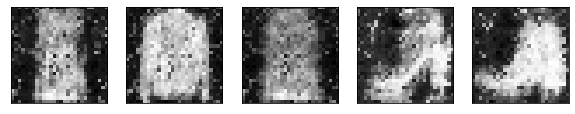

ÉPOCA 037 finalizada: custo discriminador 1.185022 - custo gerador 1.141865      


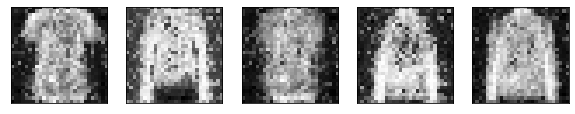

ÉPOCA 038 finalizada: custo discriminador 1.205449 - custo gerador 1.167604      


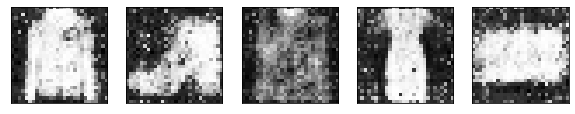

ÉPOCA 039 finalizada: custo discriminador 1.403530 - custo gerador 1.275938      


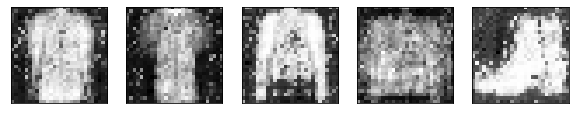

ÉPOCA 040 finalizada: custo discriminador 1.171846 - custo gerador 1.099423      


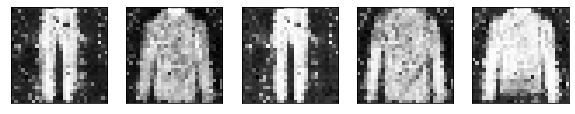

ÉPOCA 041 finalizada: custo discriminador 1.350935 - custo gerador 1.199216      


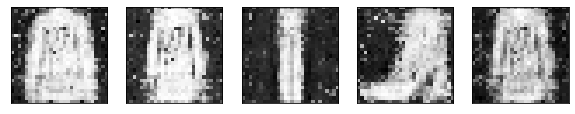

ÉPOCA 042 finalizada: custo discriminador 1.206928 - custo gerador 1.189452      


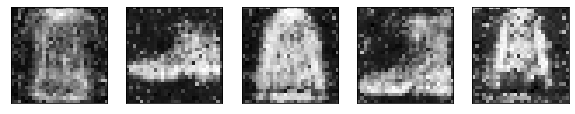

ÉPOCA 043 finalizada: custo discriminador 1.526197 - custo gerador 1.313138      


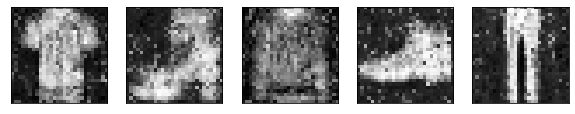

ÉPOCA 044 finalizada: custo discriminador 1.389061 - custo gerador 1.184056      


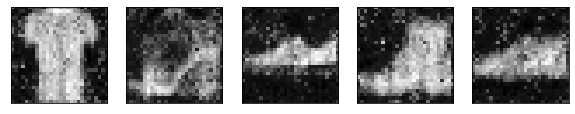

ÉPOCA 045 finalizada: custo discriminador 1.357137 - custo gerador 1.153817      


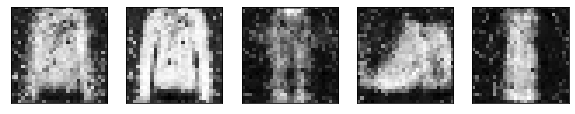

ÉPOCA 046 finalizada: custo discriminador 1.311523 - custo gerador 1.063633      


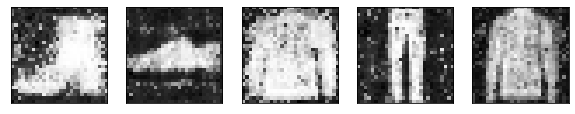

ÉPOCA 047 finalizada: custo discriminador 1.174989 - custo gerador 1.054278      


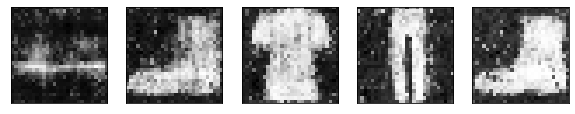

ÉPOCA 048 finalizada: custo discriminador 1.275810 - custo gerador 1.134568      


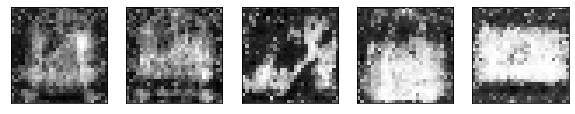

ÉPOCA 049 finalizada: custo discriminador 1.163816 - custo gerador 1.139657      


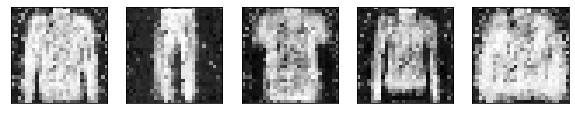

ÉPOCA 050 finalizada: custo discriminador 1.368427 - custo gerador 1.261941      


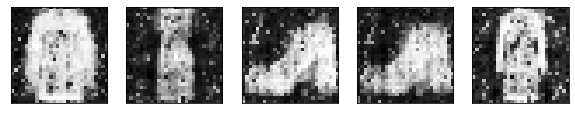

ÉPOCA 051 finalizada: custo discriminador 1.384613 - custo gerador 1.199349      


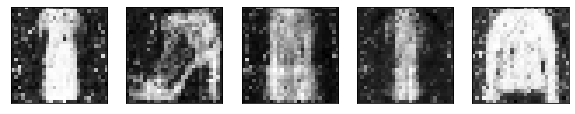

ÉPOCA 052 finalizada: custo discriminador 1.304424 - custo gerador 1.135874      


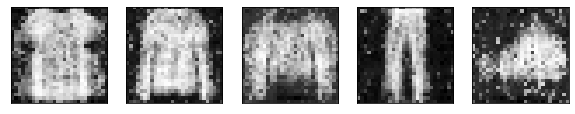

ÉPOCA 053 finalizada: custo discriminador 1.233323 - custo gerador 1.131906      


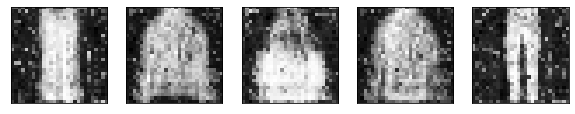

ÉPOCA 054 finalizada: custo discriminador 1.280260 - custo gerador 1.172470      


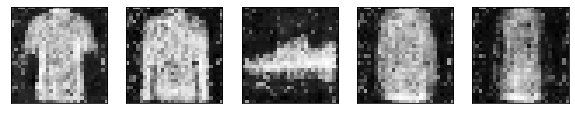

ÉPOCA 055 finalizada: custo discriminador 1.240614 - custo gerador 1.113851      


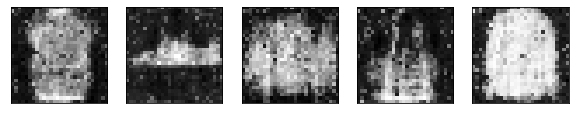

ÉPOCA 056 finalizada: custo discriminador 1.281155 - custo gerador 1.150668      


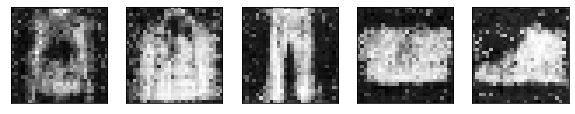

ÉPOCA 057 finalizada: custo discriminador 1.061990 - custo gerador 1.149472      


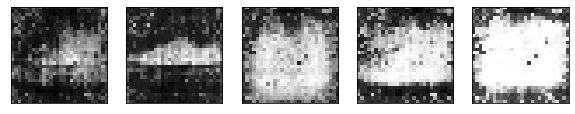

ÉPOCA 058 finalizada: custo discriminador 1.422154 - custo gerador 1.239381      


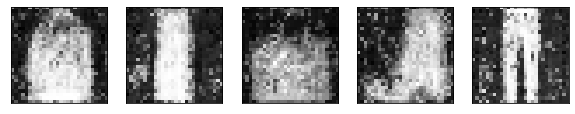

ÉPOCA 059 finalizada: custo discriminador 1.499132 - custo gerador 1.286114      


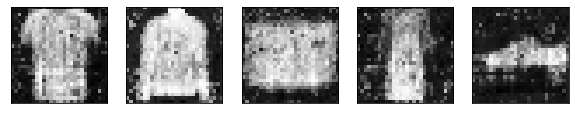

ÉPOCA 060 finalizada: custo discriminador 1.187253 - custo gerador 1.155804      


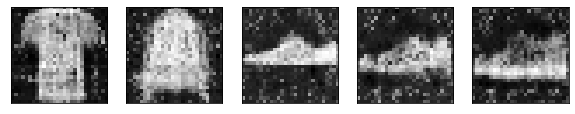

ÉPOCA 061 finalizada: custo discriminador 1.236618 - custo gerador 1.037122      


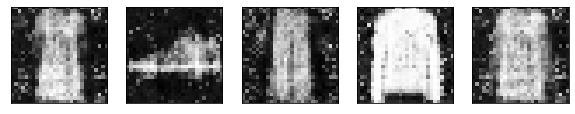

ÉPOCA 062 finalizada: custo discriminador 1.211014 - custo gerador 1.190513      


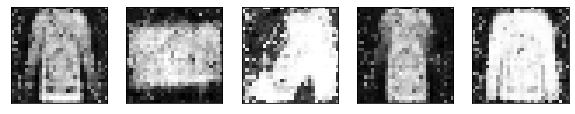

ÉPOCA 063 finalizada: custo discriminador 0.874421 - custo gerador 1.185416      


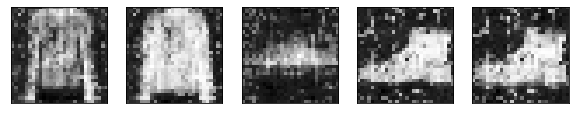

ÉPOCA 064 finalizada: custo discriminador 1.280568 - custo gerador 1.187750      


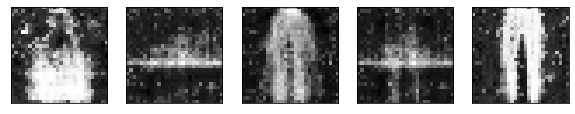

ÉPOCA 065 finalizada: custo discriminador 1.035909 - custo gerador 1.124022      


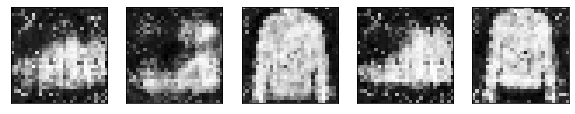

ÉPOCA 066 finalizada: custo discriminador 1.526433 - custo gerador 1.313221      


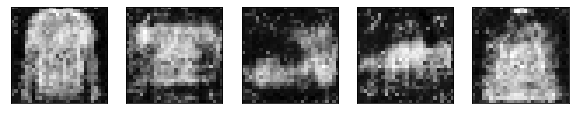

ÉPOCA 067 finalizada: custo discriminador 1.443805 - custo gerador 1.251766      


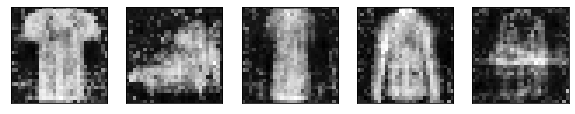

ÉPOCA 068 finalizada: custo discriminador 1.112901 - custo gerador 1.199848      


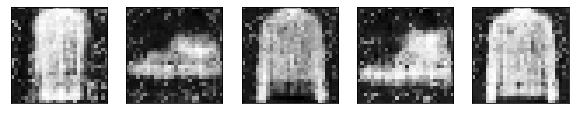

ÉPOCA 069 finalizada: custo discriminador 0.792534 - custo gerador 1.262136      


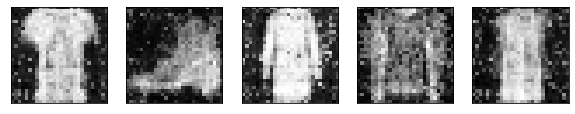

ÉPOCA 070 finalizada: custo discriminador 1.062624 - custo gerador 1.053383      


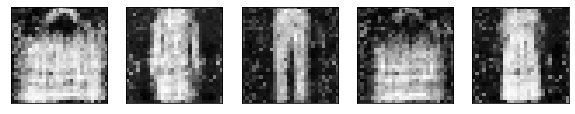

ÉPOCA 071 finalizada: custo discriminador 1.258727 - custo gerador 1.215942      


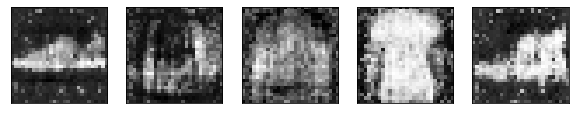

ÉPOCA 072 finalizada: custo discriminador 1.090125 - custo gerador 1.132240      


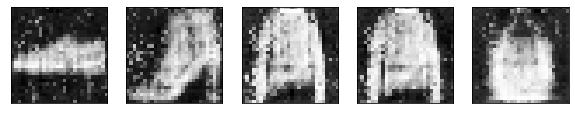

ÉPOCA 073 finalizada: custo discriminador 1.443282 - custo gerador 1.290258      


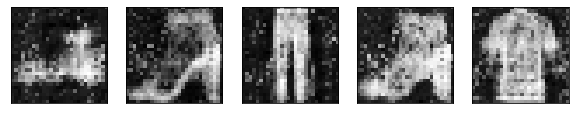

ÉPOCA 074 finalizada: custo discriminador 1.500731 - custo gerador 1.294887      


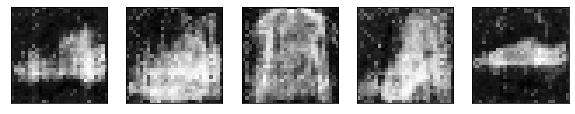

ÉPOCA 075 finalizada: custo discriminador 1.081147 - custo gerador 1.101452      


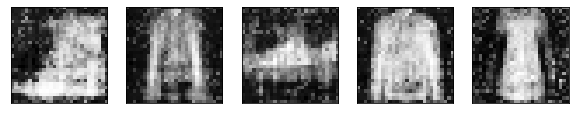

ÉPOCA 076 finalizada: custo discriminador 1.481066 - custo gerador 1.272637      


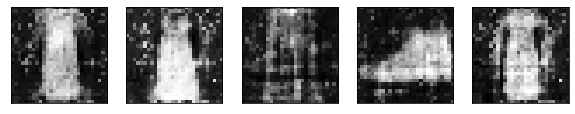

ÉPOCA 077 finalizada: custo discriminador 1.377036 - custo gerador 1.179038      


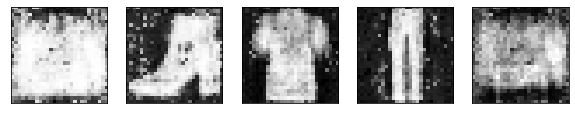

ÉPOCA 078 finalizada: custo discriminador 1.259045 - custo gerador 1.266054      


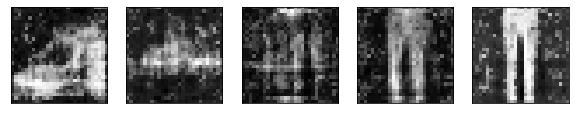

ÉPOCA 079 finalizada: custo discriminador 1.525861 - custo gerador 1.313039      


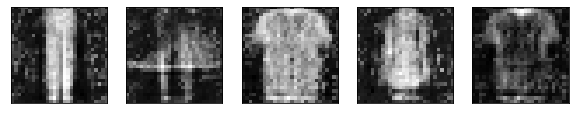

ÉPOCA 080 finalizada: custo discriminador 1.326916 - custo gerador 1.096273      


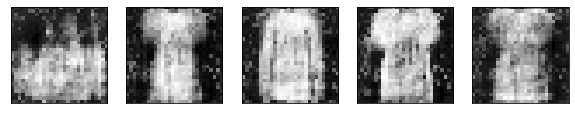

ÉPOCA 081 finalizada: custo discriminador 1.526428 - custo gerador 1.313119      


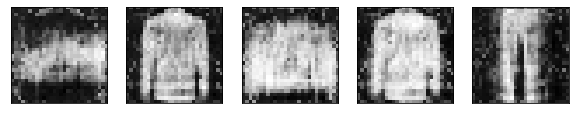

ÉPOCA 082 finalizada: custo discriminador 1.496097 - custo gerador 1.268356      


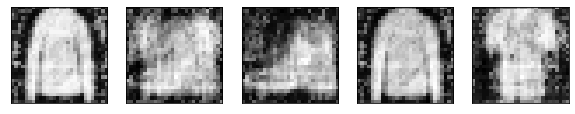

ÉPOCA 083 finalizada: custo discriminador 1.293271 - custo gerador 1.080162      


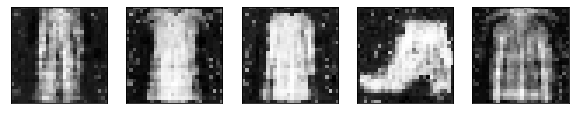

ÉPOCA 084 finalizada: custo discriminador 0.985380 - custo gerador 1.168682      


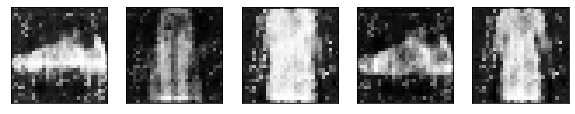

ÉPOCA 085 finalizada: custo discriminador 1.346768 - custo gerador 1.265737      


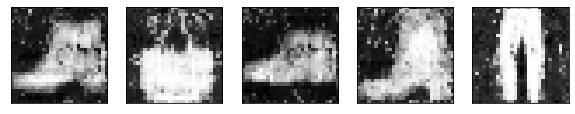

ÉPOCA 086 finalizada: custo discriminador 1.271800 - custo gerador 1.079413      


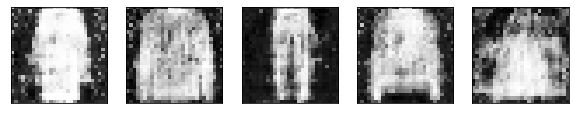

ÉPOCA 087 finalizada: custo discriminador 1.250929 - custo gerador 1.195960      


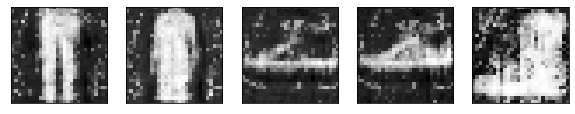

ÉPOCA 088 finalizada: custo discriminador 1.230182 - custo gerador 1.121468      


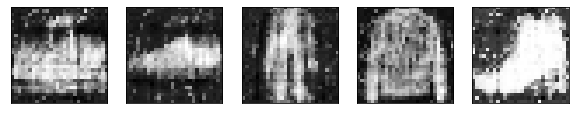

ÉPOCA 089 finalizada: custo discriminador 1.070162 - custo gerador 1.100871      


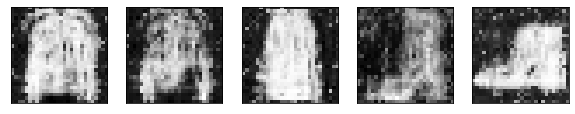

ÉPOCA 090 finalizada: custo discriminador 1.427648 - custo gerador 1.234871      


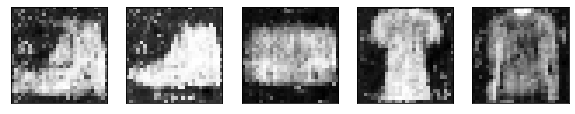

ÉPOCA 091 finalizada: custo discriminador 1.322452 - custo gerador 1.217756      


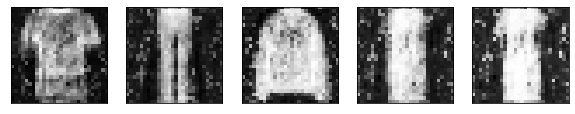

ÉPOCA 092 finalizada: custo discriminador 1.356350 - custo gerador 1.219115      


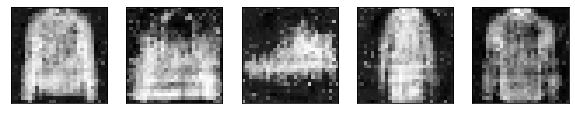

ÉPOCA 093 finalizada: custo discriminador 1.095135 - custo gerador 1.181289      


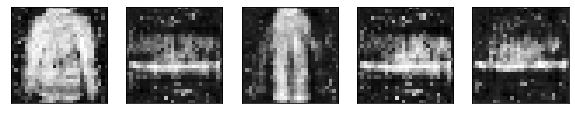

ÉPOCA 094 finalizada: custo discriminador 1.452354 - custo gerador 1.227222      


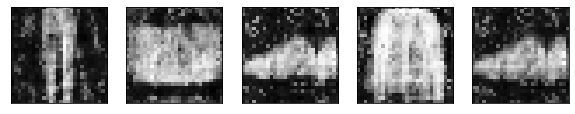

ÉPOCA 095 finalizada: custo discriminador 1.257826 - custo gerador 1.070973      


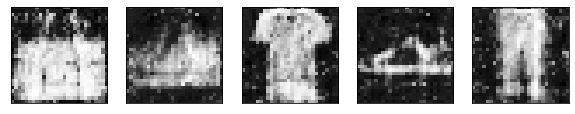

ÉPOCA 096 finalizada: custo discriminador 1.174741 - custo gerador 1.191147      


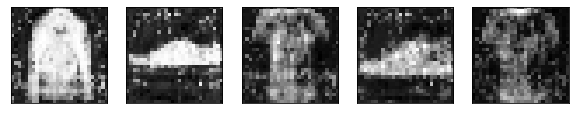

ÉPOCA 097 finalizada: custo discriminador 1.368950 - custo gerador 1.188264      


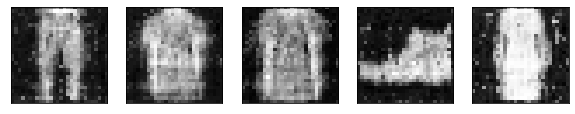

ÉPOCA 098 finalizada: custo discriminador 1.057264 - custo gerador 1.187772      


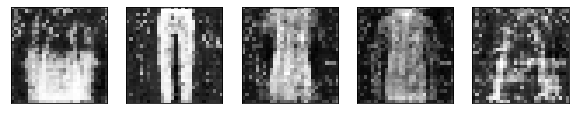

ÉPOCA 099 finalizada: custo discriminador 1.166959 - custo gerador 1.298583      


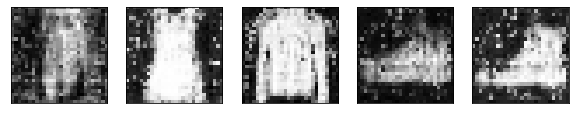

ÉPOCA 100 finalizada: custo discriminador 1.249851 - custo gerador 1.227801      


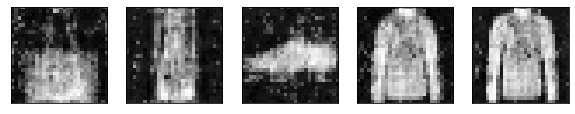

In [130]:
for epoch in range(100):
  D_run_loss = 0
  G_run_loss = 0
  
  for i, (img_raw, _) in enumerate(train_loader):
    batch_size = img_raw.size(0)
    img_raw = img_raw * 2 - 1
    img_raw = img_raw.to(device)

    #print(batch_size, i)

    # Treinamento do gerador
    G_optim.zero_grad()
    ruido = np.random.uniform(low=-1., high=1., size=(batch_size, 1, 28, 28))
    ruido = torch.from_numpy(ruido).float().to(device)
    img_gen = G.forward(ruido)

    outputs_gen = D.forward(img_gen * 2 - 1)
    labels_gen = torch.ones(batch_size).to(device)
    G_loss = criterion(outputs_gen.view(*labels_gen.shape), labels_gen)
    G_loss.backward()
    G_optim.step()

    # Treinamento do discriminador
    D_optim.zero_grad()
    outputs_raw = D.forward(img_raw.reshape(-1,28*28,1,1))
    labels_raw = (torch.ones(batch_size) * 0.9).to(device)
    D_loss_raw = criterion(outputs_raw.view(*labels_raw.shape), labels_raw)

    ruido = np.random.uniform(-1., 1., (batch_size, 1, 28, 28))
    ruido = torch.from_numpy(ruido).float().to(device)
    img_gen = G.forward(ruido)

    outputs_gen = D.forward(img_gen * 2 - 1)
    labels_gen = torch.zeros(batch_size).to(device)
    D_loss_gen = criterion(outputs_gen.view(*labels_gen.shape), labels_gen)

    D_loss = D_loss_raw + D_loss_gen
    D_loss.backward()
    D_optim.step()

    D_run_loss += D_loss.item()
    G_run_loss += G_loss.item()

    # Imprimindo os dados referentes a esse batch   
    print('\rÉpoca {:03d} - Loop {:3d} de {:3d}: custo discriminador {:03.5f} - custo gerador {:03.5f}'\
          .format(epoch + 1, i + 1, len(train_loader), D_loss.item(), G_loss.item()), end = '\r')

  # Imprimindo os dados referentes a essa época
  D_run_loss /= len(train_loader)
  G_run_loss /= len(train_loader)
  
  print('ÉPOCA {:03d} finalizada: custo discriminador {:03.6f} - custo gerador {:03.6f}      '\
        .format(epoch + 1, D_run_loss, G_run_loss))
  
  fig, ax = plt.subplots(1, 5, figsize=(10,5))
  for i in range(5):
    ax[i].imshow(img_gen.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
  plt.show()

## Etapa 7: Criação de novas imagens

In [156]:
ruido = np.random.uniform(-1,1,(20,1,28,28))
ruido.shape

(20, 1, 28, 28)

In [157]:
ruido = torch.from_numpy(ruido).float().to(device)

In [158]:
type(ruido)

torch.Tensor

In [159]:
G.eval()
previsao = G.forward(ruido)

In [160]:
previsao = previsao.cpu().detach().numpy()

In [161]:
previsao.shape

(20, 28, 28)

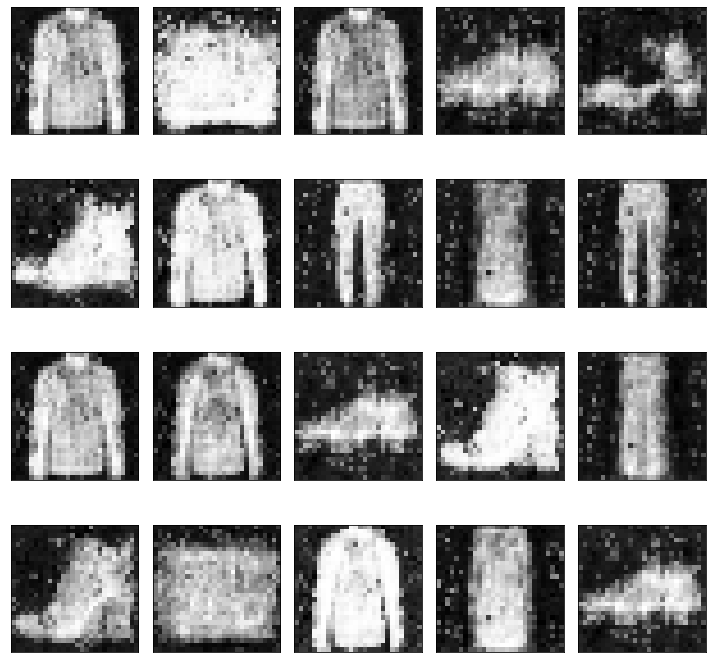

In [164]:
fig, ax = plt.subplots(4,5, figsize=(10,10))
r, c = 0, 0
for i in range(previsao.shape[0]):
  ax[r][c].imshow(previsao[i, :].squeeze(), cmap='gray')
  
  ax[r][c].xaxis.set_visible(False)
  ax[r][c].yaxis.set_visible(False)
  c = 0 if c == 4 else c + 1
  r = 0 if r == 3 else r + 1

plt.tight_layout()
plt.show()